# Desafio de Previsão de Gastos em Saúde<br>

Disponível em [FreeCodeCamp](https://www.freecodecamp.org/learn/machine-learning-with-python/machine-learning-with-python-projects/linear-regression-health-costs-calculator).

Além da importancia de projetar gastos na área da saúde a capacidade de prever gastos também pode abordar outro ponto muito importante para o tema, a identificação de quais fatores podem influenciar nesse resultado, poís além de entender a influencia de cada característica nos gastos podemos também evidenciar quais características ou hábitos podem ser alterados ou trabalhados para diminuir esses gastos.

Esse conhecimento pode direcionar melhor as decisões e conscientizar pacientes sobre hábitos nocivos a sua própria saúde, fazendo a tomada de decisão em saúde de uma melhor forma. Além disso campanhas de conscientização podem ser elaboradas com maior eficácia por parte de instituições e órgãos públicos de saúde.

Para esse desafio foi proposto o uso de modelo de regressão linear para encontrar um modelo que consiga prever os gastos com Erro Absoluto Médio (Mean Absolute Erros - MAE) abaixo de $3500.

Também vamos tentar responder as seguintes perguntas:

1.Hábitos saudáveis influenciam nos gastos em saúde?

2.Quais hábitos poderiam ser mudados para diminuir gastos e promover melhor saúde?

# 1.Importando bibliotecas

In [1]:
# Bibliotecas nativas
import time

# Bibliotecas externas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import (RFE, SelectFromModel, SelectKBest,
                                     f_regression, mutual_info_regression)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNetCV, LassoCV, LinearRegression, RidgeCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
from sklearn.model_selection import (KFold, cross_val_score, learning_curve,
                                     train_test_split, validation_curve)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (MinMaxScaler, OneHotEncoder,
                                   PolynomialFeatures, RobustScaler,
                                   StandardScaler)

# Estilo e formatação
plt.style.use('ggplot')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 2.Importando dataset e informações gerais

In [2]:
df = pd.read_csv('data/gastos_saude.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.sample(10)

,age,sex,bmi,children,smoker,region,expenses
526,19,female,30.600,2,no,northwest,24059.680
677,60,male,31.400,3,yes,northwest,46130.530
657,27,male,33.200,2,no,northwest,4058.710
812,54,male,21.000,2,no,southeast,11013.710
886,57,male,29.000,0,yes,northeast,27218.440
48,60,female,24.500,0,no,southeast,12629.900
91,53,female,24.800,1,no,northwest,10942.130
1213,52,female,33.300,2,no,southwest,10806.840
1017,26,female,34.200,2,no,southwest,3987.930
493,61,male,43.400,0,no,southwest,12574.050


# 3.Análise descritiva

## Univariada

### Variáveis numéricas

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.000,39.207,14.050,18.000,27.000,39.000,51.000,64.000
bmi,1338.000,30.665,6.098,16.000,26.300,30.400,34.700,53.100
children,1338.000,1.095,1.205,0.000,0.000,1.000,2.000,5.000
expenses,1338.000,13270.422,12110.011,1121.870,4740.288,9382.030,16639.915,63770.430


Podemos observar alguns detalhes iniciais:
- A idade possui média e mediana proxima, indicando que possivelmente não há outliers desequilibrando as métricas e os intervalos dos quartis estão relativamente equilibrados

- O imc aparentemente tem distribuição normal, e também esta balanceado quantos aos intervalos dos quartis, assim como média e medianas proximas. Aparentemente possui alguns valores extremos maximo. Teremos que confirmar nos gráficos.

- O número de filhos mostra que 75% das pessoas tem até 2 filhos (terceiro quartil) ou seja, um número reduzido de pessoas tem mais que dois filhos.

- Já para o valor gasto temos provavelmente uma distribuição assimétrica e com valores extremos, pois temos 75% das observações com até 16mil de gastos, e o valor máximo chega a quase 4 vezes mais. Isso pode também ser notado pelos valores de média e mediana, respectivamente por volta de 13mil e 9mil. Confirmaremos também nos gráficos.

In [6]:
# Selecionando colunas com variáveis numéricas
num_col = df.select_dtypes(include='number').columns

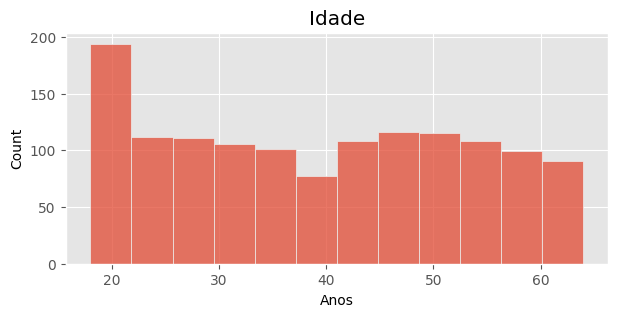

In [7]:
plt.figure(figsize=(7, 3))
sns.histplot(data=df, x=num_col[0])
plt.title('Idade')
plt.xlabel('Anos')
plt.show()

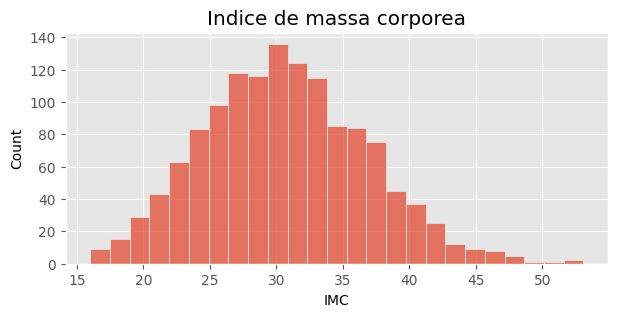

In [8]:
plt.figure(figsize=(7, 3))
sns.histplot(data=df, x=num_col[1])
plt.title('Indice de massa corporea')
plt.xlabel('IMC')
plt.show()

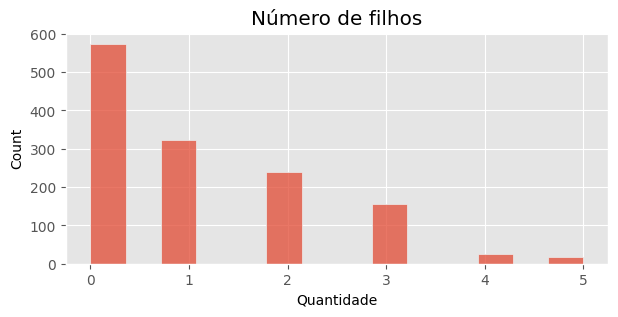

In [9]:
plt.figure(figsize=(7, 3))
sns.histplot(data=df, x=num_col[2])
plt.title('Número de filhos')
plt.xlabel('Quantidade')
plt.show()

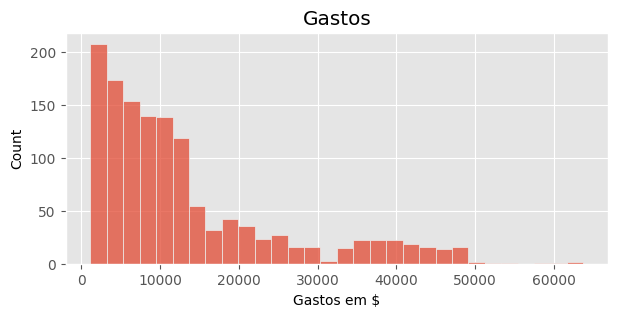

In [10]:
plt.figure(figsize=(7, 3))
sns.histplot(data=df, x=num_col[3])
plt.title('Gastos')
plt.xlabel('Gastos em $')
plt.show()

Pelos gráficos confirmamos as suspeitas levantadas inicialmente. Os valores de imc tem distribuição normal, ou próximo, há predomínio de pessoas com até 2 filhos, e os gastos tem distribuição não normal com alguns outliers nos maiores valores. Podemos observar que há um equilíbrio na idade dos participantes, com uma quatidade elevada de pessoas mais jovens, proxima dos 20 anos

### Variáveis categóricas

In [11]:
df.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [12]:
# Selecionando variáveis categóricas
cat_col = df.select_dtypes(include='object').columns

In [13]:
# Verificando valores por categorias iterando sobre a lista de variáveis categóricas
for item in cat_col:
    print(df[item].value_counts().to_frame().T)
    print("=" * 50)

     male  female
sex   676     662
          no  yes
smoker  1064  274
        southeast  southwest  northwest  northeast
region        364        325        325        324


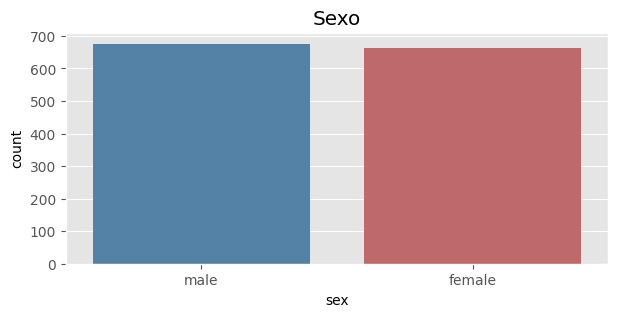

In [14]:
plt.figure(figsize=(7, 3))
sns.countplot(data=df, x=cat_col[0], 
              order=df[cat_col[0]].value_counts().index, 
              palette={'male':'steelblue', 'female':'indianred'})
plt.title('Sexo')
plt.show()

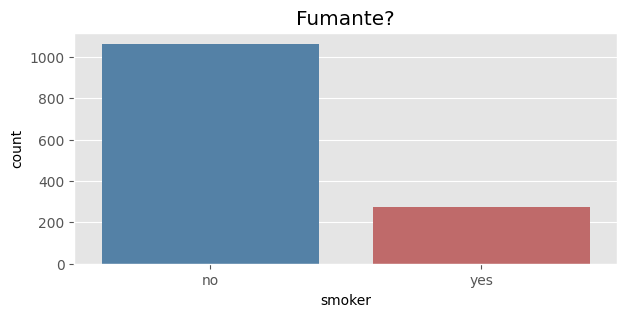

In [15]:
plt.figure(figsize=(7,3))
sns.countplot(data=df, x=cat_col[1], 
              order=df[cat_col[1]].value_counts().index, 
              palette={'no':'steelblue', 'yes':'indianred'})
plt.title('Fumante?')
plt.show()

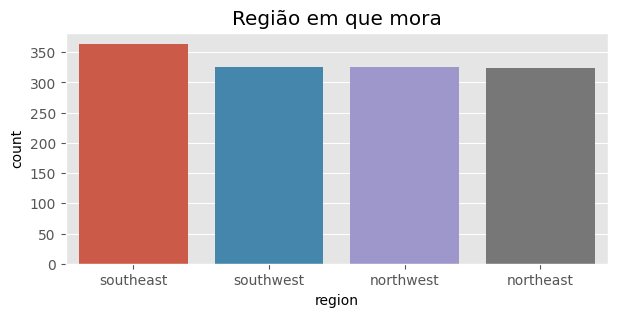

In [16]:
plt.figure(figsize=(7,3))
sns.countplot(data=df, x=cat_col[2], 
              order=df[cat_col[2]].value_counts().index)
plt.title('Região em que mora')
plt.show()

Observamos que não há desequilíbrio em relação ao sexo, e quanto a região em que os participantes da amostra moram. Porém em relação ao tabagismo observamos que não fumantes e fumantes estão em uma proporção de quase 4:1. Investigaremos essas diferenças mais a frente nas análises bi e multivariadas.

## Bivariada

### Variáveis numéricas x numéricas

Aqui vamos utilizar o "pairplot", uma visualização mostrando a interação entre variáveis numéricas. Podemso estipular quantas variáveis queremos analisar, mas nesse caso por termos poucas variáveis faremos a visualização de todas elas.

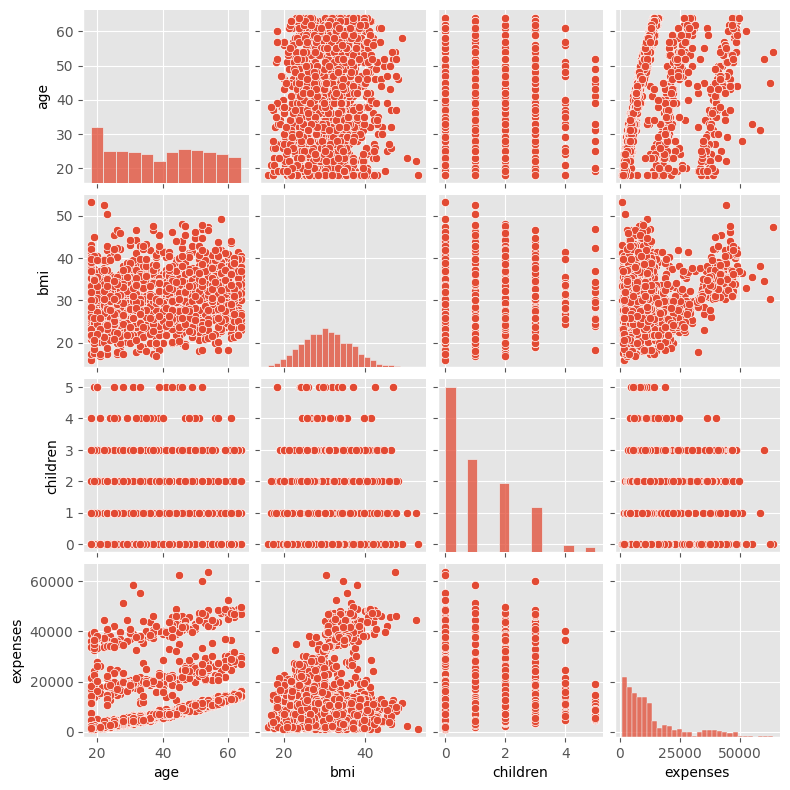

In [17]:
sns.pairplot(df, height=2)

Observando a ultima linha vemos que para a vaiável de interesse "expenses" possivelmente há alguma interação com idade e imc, pois conseguimos identificar alguns padrões para essas duas outras variáveis, sendo uma correlação positiva com imc e algumas faixas de valores de gasto com a idade.

Essa informação tem alguma fundamentação na literatura, pois há indícios de aumento de gastos com a idade e em alguns casos e cenários proporção diretamente proporcional de gastos com imc.

### Variáveis categóricas x numéricas

Para variáveis cateóricas usaremos o método "groupby", que separa o conjunto de dados de acordo com a váriavel de interesse. Isso facilita avaliarmos as características dentro de determinados grupos.

Vamos utilizar visualizações para facilitar o entendimento dessas interações.

#### Sexo

In [18]:
df.groupby('sex')['age'].describe().T

sex,female,male
count,662.000,676.000
mean,39.503,38.917
std,14.054,14.050
min,18.000,18.000
25%,27.000,26.000
50%,40.000,39.000
75%,51.750,51.000
max,64.000,64.000


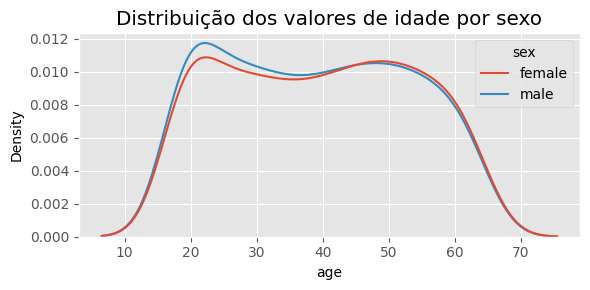

In [19]:
plt.figure(figsize=(6, 3))
sns.kdeplot(data=df, x ='age', hue='sex')
plt.title('Distribuição dos valores de idade por sexo')
plt.tight_layout()

In [20]:
df.groupby('sex')['bmi'].describe().T

sex,female,male
count,662.000,676.000
mean,30.380,30.945
std,6.047,6.140
min,16.800,16.000
25%,26.100,26.400
50%,30.100,30.700
75%,34.300,35.025
max,48.100,53.100


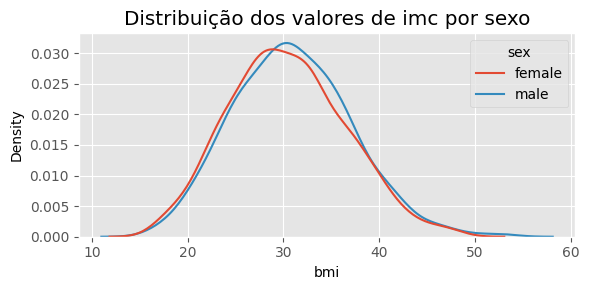

In [21]:
plt.figure(figsize=(6, 3))
sns.kdeplot(data=df, x='bmi', hue='sex')
plt.title('Distribuição dos valores de imc por sexo')
plt.tight_layout()

In [22]:
df.groupby('sex')['expenses'].describe().T

sex,female,male
count,662.000,676.000
mean,12569.579,13956.751
std,11128.704,12971.026
min,1607.510,1121.870
25%,4885.163,4619.135
50%,9412.965,9369.615
75%,14454.690,18989.595
max,63770.430,62592.870


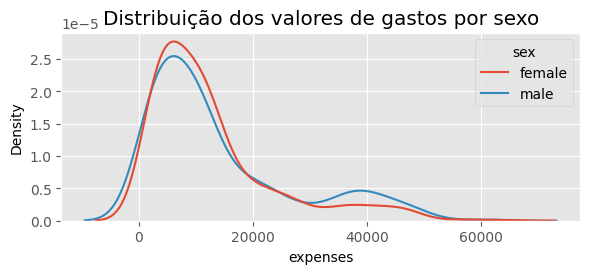

In [23]:
plt.figure(figsize=(6, 3))
sns.kdeplot(data=df, x='expenses', hue='sex')
plt.title('Distribuição dos valores de gastos por sexo')
plt.tight_layout()

In [24]:
df.groupby('sex')['children'].describe().T

sex,female,male
count,662.000,676.000
mean,1.074,1.115
std,1.192,1.219
min,0.000,0.000
25%,0.000,0.000
50%,1.000,1.000
75%,2.000,2.000
max,5.000,5.000


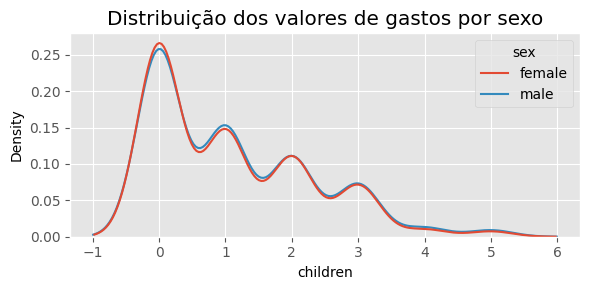

In [25]:
plt.figure(figsize=(6, 3))
sns.kdeplot(data=df, x='children', hue='sex')
plt.title('Distribuição dos valores de gastos por sexo')
plt.tight_layout()

#### Tabagismo

In [26]:
df.groupby('smoker')['age'].describe().T

smoker,no,yes
count,1064.000,274.000
mean,39.385,38.515
std,14.083,13.923
min,18.000,18.000
25%,26.750,27.000
50%,40.000,38.000
75%,52.000,49.000
max,64.000,64.000


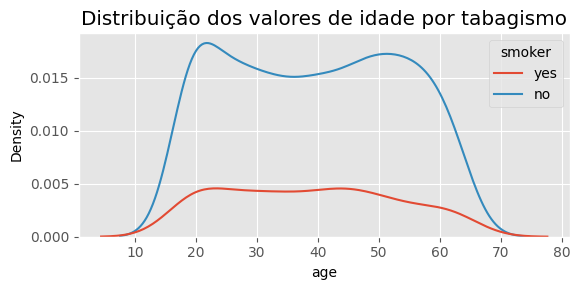

In [27]:
plt.figure(figsize=(6, 3))
sns.kdeplot(data=df, x='age', hue='smoker')
plt.title('Distribuição dos valores de idade por tabagismo')
plt.tight_layout()

In [29]:
df.groupby('smoker')['bmi'].describe().T

smoker,no,yes
count,1064.000,274.000
mean,30.653,30.713
std,6.043,6.321
min,16.000,17.200
25%,26.300,26.100
50%,30.350,30.450
75%,34.400,35.200
max,53.100,52.600


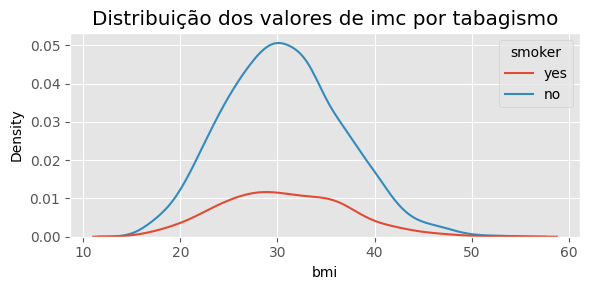

In [28]:
plt.figure(figsize=(6, 3))
sns.kdeplot(data=df, x='bmi', hue='smoker')
plt.title('Distribuição dos valores de imc por tabagismo')
plt.tight_layout()

In [30]:
df.groupby('smoker')['expenses'].describe().T

smoker,no,yes
count,1064.000,274.000
mean,8434.268,32050.232
std,5993.782,11541.547
min,1121.870,12829.460
25%,3986.443,20826.245
50%,7345.405,34456.350
75%,11362.890,41019.205
max,36910.610,63770.430


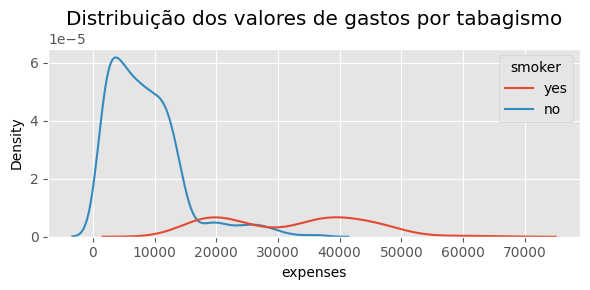

In [31]:
plt.figure(figsize=(6, 3))
sns.kdeplot(data=df, x='expenses', hue='smoker')
plt.title('Distribuição dos valores de gastos por tabagismo')
plt.tight_layout()

In [32]:
df.groupby('smoker')['children'].describe().T

smoker,no,yes
count,1064.000,274.000
mean,1.090,1.113
std,1.218,1.157
min,0.000,0.000
25%,0.000,0.000
50%,1.000,1.000
75%,2.000,2.000
max,5.000,5.000


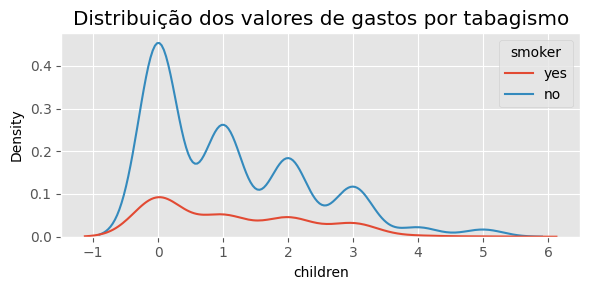

In [33]:
plt.figure(figsize=(6, 3))
sns.kdeplot(data=df, x='children', hue='smoker')
plt.title('Distribuição dos valores de gastos por tabagismo')
plt.tight_layout()

#### Região

In [34]:
df.groupby('region')['age'].describe().T

region,northeast,northwest,southeast,southwest
count,324.000,325.000,364.000,325.000
mean,39.269,39.197,38.940,39.455
std,14.069,14.052,14.165,13.960
min,18.000,19.000,18.000,19.000
25%,27.000,26.000,26.750,27.000
50%,39.500,39.000,39.000,39.000
75%,51.000,51.000,51.000,51.000
max,64.000,64.000,64.000,64.000


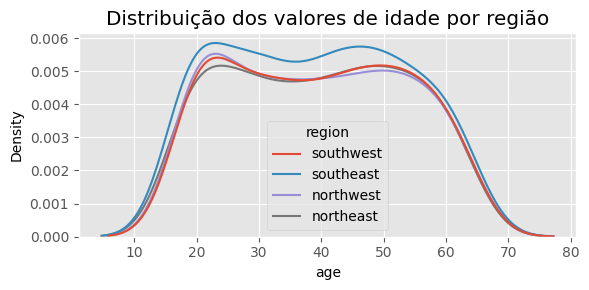

In [35]:
plt.figure(figsize=(6, 3))
sns.kdeplot(data=df, x='age', hue='region')
plt.title('Distribuição dos valores de idade por região')
plt.tight_layout()

In [36]:
df.groupby('region')['bmi'].describe().T

region,northeast,northwest,southeast,southwest
count,324.000,325.000,364.000,325.000
mean,29.176,29.202,33.359,30.597
std,5.937,5.136,6.479,5.692
min,16.000,17.400,19.800,17.400
25%,24.875,25.700,28.575,26.900
50%,28.900,28.900,33.300,30.300
75%,32.925,32.800,37.800,34.600
max,48.100,42.900,53.100,47.600


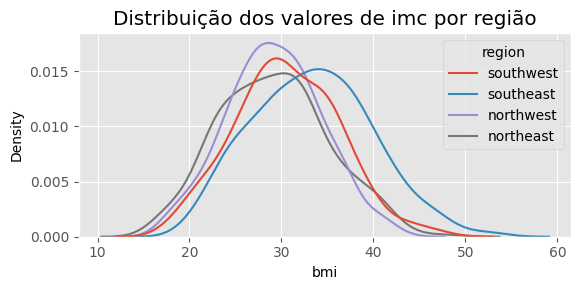

In [37]:
plt.figure(figsize=(6, 3))
sns.kdeplot(data=df, x='bmi', hue='region')
plt.title('Distribuição dos valores de imc por região')
plt.tight_layout()

In [38]:
df.groupby('region')['expenses'].describe().T

region,northeast,northwest,southeast,southwest
count,324.000,325.000,364.000,325.000
mean,13406.385,12417.575,14735.412,12346.938
std,11255.803,11072.277,13971.099,11557.179
min,1694.800,1621.340,1121.870,1241.570
25%,5194.323,4719.740,4440.885,4751.070
50%,10057.655,8965.800,9294.130,8798.590
75%,16687.365,14711.740,19526.288,13462.520
max,58571.070,60021.400,63770.430,52590.830


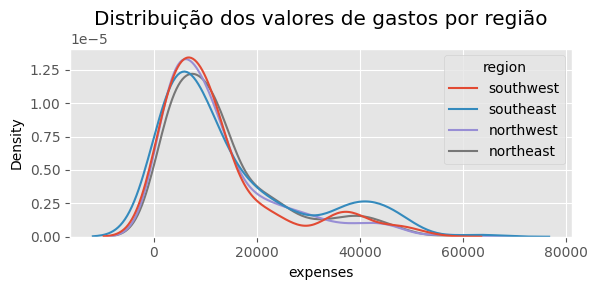

In [39]:
plt.figure(figsize=(6, 3))
sns.kdeplot(data=df, x='expenses', hue='region')
plt.title('Distribuição dos valores de gastos por região')
plt.tight_layout()

In [40]:
df.groupby('region')['children'].describe().T

region,northeast,northwest,southeast,southwest
count,324.000,325.000,364.000,325.000
mean,1.046,1.148,1.049,1.142
std,1.199,1.172,1.177,1.276
min,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000
50%,1.000,1.000,1.000,1.000
75%,2.000,2.000,2.000,2.000
max,5.000,5.000,5.000,5.000


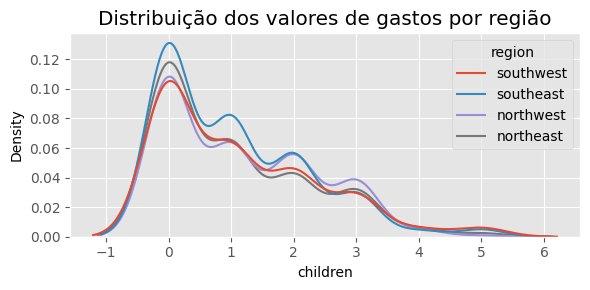

In [41]:
plt.figure(figsize=(6, 3))
sns.kdeplot(data=df, x='children', hue='region')
plt.title('Distribuição dos valores de gastos por região')
plt.tight_layout()

In [42]:
df.groupby('sex')['expenses'].describe().T

sex,female,male
count,662.000,676.000
mean,12569.579,13956.751
std,11128.704,12971.026
min,1607.510,1121.870
25%,4885.163,4619.135
50%,9412.965,9369.615
75%,14454.690,18989.595
max,63770.430,62592.870


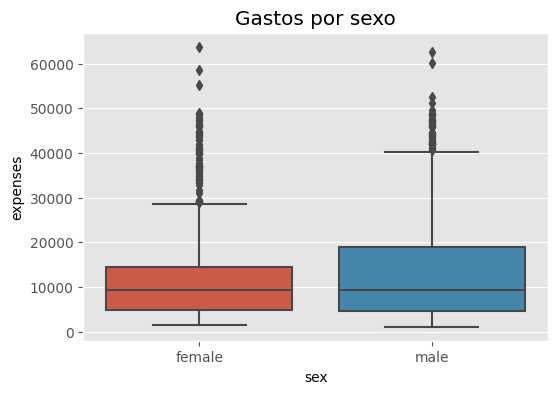

In [43]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='sex', y='expenses')
plt.title('Gastos por sexo')
plt.show()

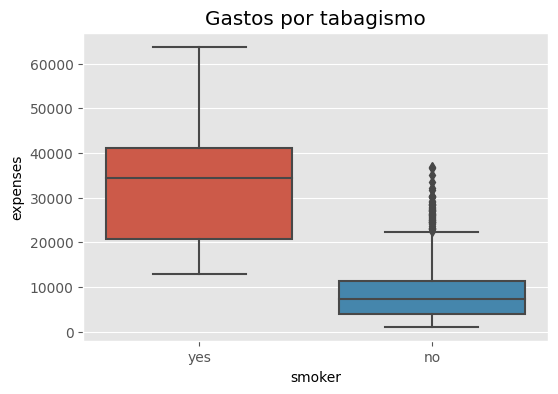

In [44]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='smoker', y='expenses')
plt.title('Gastos por tabagismo')
plt.show()

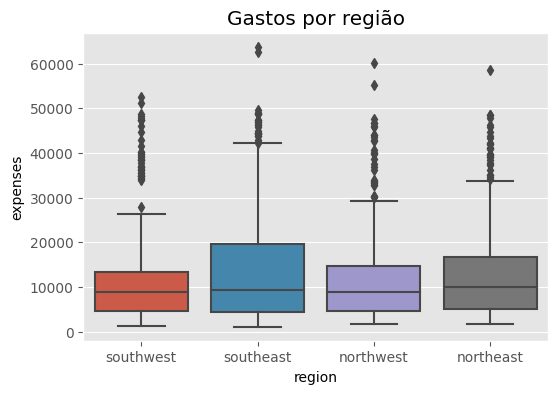

In [45]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='region', y='expenses')
plt.title('Gastos por região')
plt.show()

Para as variáveis numéricas temos uma sobreposição das distribuições com todas as variáveis categóricas.7

Isso ocorre exceto quando avaliamos se a pessoa é tabagista ou não e os gastos que teve em saúde. Nesse caso podemos observar que a distribuição dos valores de quem não é tabagista se concentra nos valores mais baixos, enquanto que para os fumantes os valores para gastos estão em maior número entre 20 a 40mil, chegando até a 60mil. Há também uma discrepancia ente valores de média (quase 4 vezes maior para pessoas fumantes) e todos os outros quartis.

Como já levantado anteriormente um dos fatores que podem influenciar gastos, por estar relacionado com morbidades e comorbidades é o tabagismo, e provavelmente essa característica será importante para o nosso modelo.


In [46]:
df.groupby('smoker')['expenses'].describe().T

smoker,no,yes
count,1064.000,274.000
mean,8434.268,32050.232
std,5993.782,11541.547
min,1121.870,12829.460
25%,3986.443,20826.245
50%,7345.405,34456.350
75%,11362.890,41019.205
max,36910.610,63770.430


### Features categóricas x categóricas

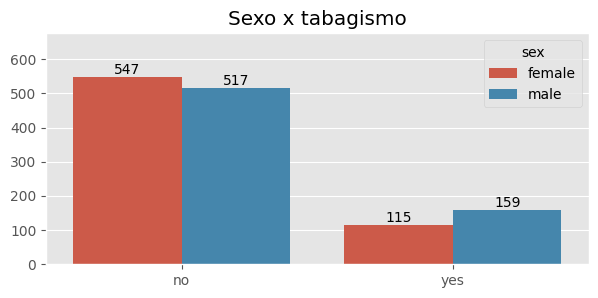

In [49]:
plt.figure(figsize=(7, 3))
ax = sns.countplot(data=df, x='smoker', hue='sex',
                   order={'no', 'yes'})
plt.title('Sexo x tabagismo')
plt.ylim([0, df['sex'].value_counts().max()])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.ylabel("")
plt.xlabel("")
plt.show()

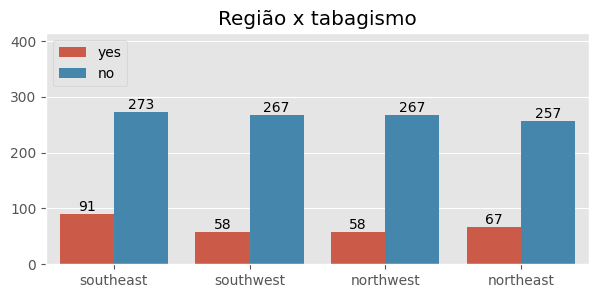

In [51]:
plt.figure(figsize=(7, 3))
ax = sns.countplot(data=df, x='region', hue='smoker',
                   order=df['region'].value_counts().index)
plt.title('Região x tabagismo')
plt.ylim([0, df['region'].value_counts().max() + 50])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.legend(loc='upper left')
plt.ylabel("")
plt.xlabel("")
plt.show()

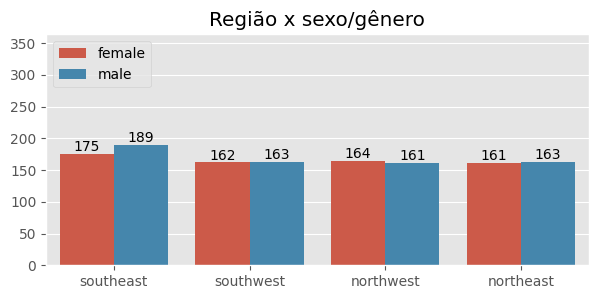

In [52]:
plt.figure(figsize=(7, 3))
ax = sns.countplot(data=df, x='region', hue='sex',
                   order=df['region'].value_counts().index)
plt.title('Região x sexo/gênero')
plt.ylim([0, df['region'].value_counts().max()])
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.legend(loc='upper left')
plt.ylabel("")
plt.xlabel("")
plt.show()

## Multivariada

Na análise multivariada investigaremos a interação de mais de duas variáveis. Focaremos na análise da variável de interesse, "expenses".

### Gastos x imc x features categóricas

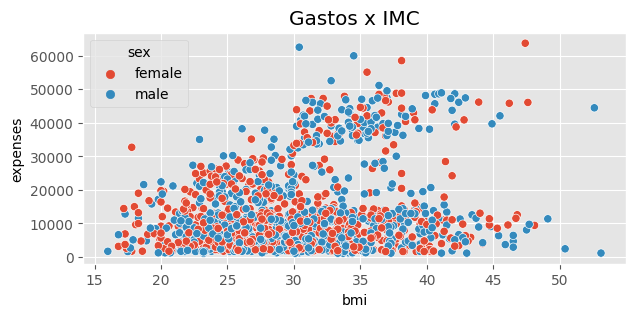

In [53]:
plt.figure(figsize=(7, 3))
sns.scatterplot(data=df, x='bmi', y='expenses', hue=cat_col[0])
plt.title('Gastos x IMC')
plt.show()

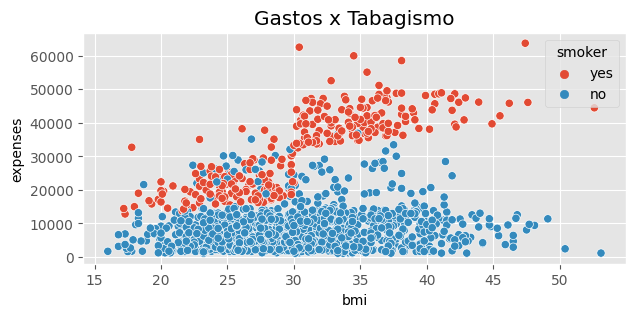

In [54]:
plt.figure(figsize=(7, 3))
sns.scatterplot(data=df, x='bmi', y='expenses', hue=cat_col[1])
plt.title('Gastos x Tabagismo')
plt.show()

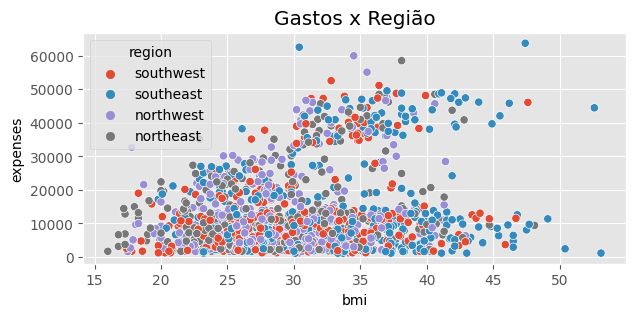

In [55]:
plt.figure(figsize=(7, 3))
sns.scatterplot(data=df, x='bmi', y='expenses', hue=cat_col[2])
plt.title('Gastos x Região')
plt.show()

### Gastos x idade x features categóricas

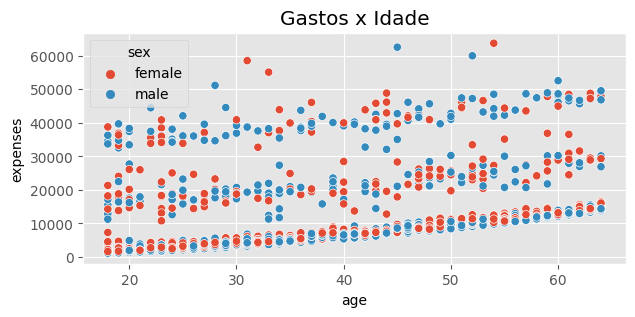

In [56]:
plt.figure(figsize=(7, 3))
sns.scatterplot(data=df, x='age', y='expenses', hue=cat_col[0])
plt.title('Gastos x Idade')
plt.show()

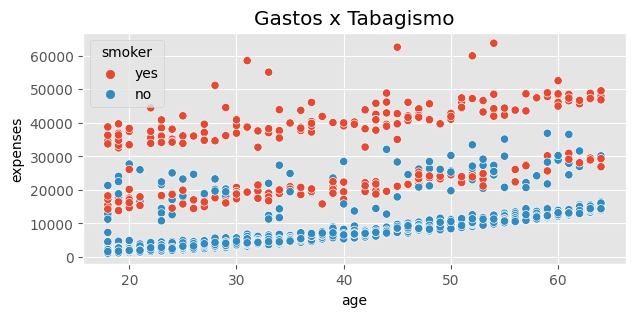

In [57]:
plt.figure(figsize=(7, 3))
sns.scatterplot(data=df, x='age', y='expenses', hue=cat_col[1])
plt.title('Gastos x Tabagismo')
plt.show()

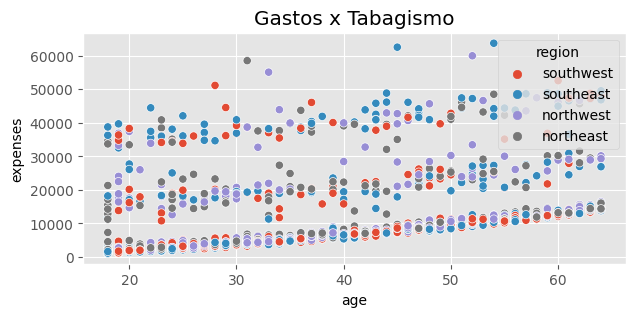

In [58]:
plt.figure(figsize=(7, 3))
sns.scatterplot(data=df, x='age', y='expenses', hue=cat_col[2])
plt.title('Gastos x Tabagismo')
plt.show()

Observamos pelo gráfico de dispersão que padrões emergem da interação de mais de 2 variáveis (faixas de valores que separam grupos relativamente bem delineados), sendo possível notar que tabagismo, idade e imc podem ser variáveis importantes para prever os gastos.<br>
<br>

# 4.Pré-processamento

Para aplicar muitos modelos de machine learning devemos seguir algumas etapas para torna-lo mais confiável. A primeira etapa consiste em dividir o nosso conjunto de dados em dados de treino e dados de teste. Essa abordagem possibilita alimentarmos o nosso modelo com os dados de treino para que seja feita a aprendizagem do comportamento dos dados e como suas características podem explicar a variável de interesse. Após o modelo aprender com nossos dados de treino podemos então mostrar novos dados nunca vistos por esse modelo treinado e pedir para ele estimar qual a resposta para esse conjunto. É muito importante que essa divisão seja a primeira etapa pois assim evitamos um problema importante o "vazamento de dados" (ou "data leakage")

## Train test split

In [59]:
# Separando a variável alvo e as variáveis com as características dos pacientes 
X = df.drop('expenses', axis=1)
Y = df['expenses']

# Utilizando o método train_test_split para dividir nosso conjunto de dados em treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.33, 
                                                    random_state=42)

## Transformações e encodings

Após dividir nossa dados devemos fazer algumas adequações para que nosso modelo possa executar as operações necesárias.

### Variáveis numéricas

Ao utilizarmos variáveis numéricas devemos nos atentar as escalas em que elas se encontram. O motivo disso é que podemos ter variáveis em escala muito maior do que outras podendo alterar a real influência que a variável tem no modelo. Por exemplo, uma variável mensurando tempo ou moeda podem alcançar a casa dos centenas e dos milhares enquanto que outras, como no nosso exemplo, idade, imc e numero de filhos, chegam no máximo a dezenas, tenho pesos diferentes e estimando uma importancia maior ou menor para o modelo, ocasionando em resultados distorcidos. Com alguns transformadores podemos "forçar" as variáveis a estarem numa escala mais adequada.

Para contornar essa questão devemos padronizar os valores e para isso usaremos 3 possibilidades (disponibilizadas na biblioteca Scikit-Learn):
- MinMaxScaler: transforma todos os valores de uma coluna numa escala entre 0 e 1
- StandardScaler: transforma todos os valores em uma escala em que a média é 0 e desvio padrão 1
- RobustScaler: similar ao standardscaler, porém transforma os valores levando em conta a distancia interquartil

Vamos implementar essas 3 transformações abaixo.

#### MinMaxScaler

In [60]:
x_train_num = x_train.select_dtypes('number')

In [61]:
minmax = MinMaxScaler()
x_train_num_minmax = minmax.fit_transform(x_train_num)
df_num_minmax = pd.DataFrame(x_train_num_minmax, 
                             columns=x_train_num.columns)


#### StandardScaler

In [62]:
s_scaler = StandardScaler()
x_train_num_s_scaler = s_scaler.fit_transform(x_train_num)
df_num_s_scaler = pd.DataFrame(x_train_num_s_scaler, 
                               columns=x_train_num.columns)

#### RobustScaler

In [63]:
r_scaler = RobustScaler()
x_train_num_r_scaler = r_scaler.fit_transform(x_train_num)
df_num_r_scaler = pd.DataFrame(x_train_num_r_scaler, 
                               columns=x_train_num.columns)

#### Visualização das transformações

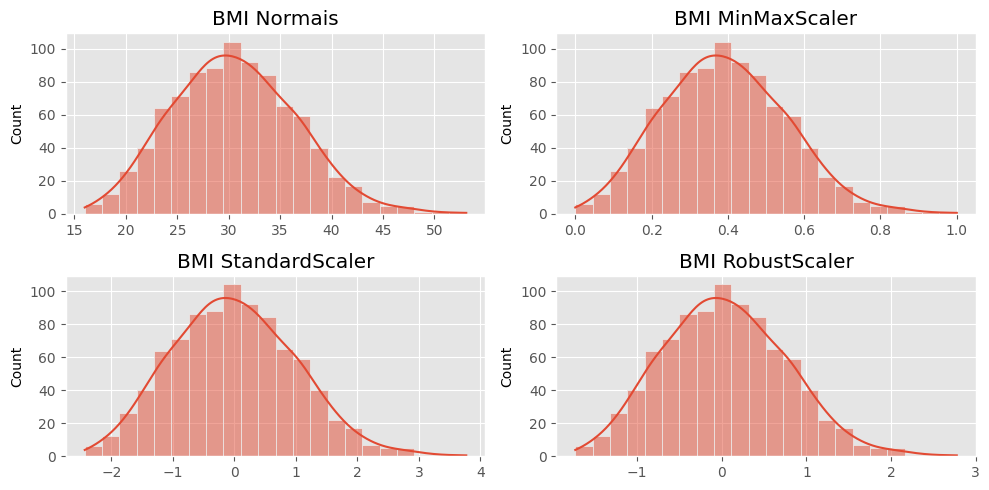

In [64]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1).set_title('BMI Normais')
sns.histplot(data=x_train, x='bmi', kde=True)
plt.xlabel("")

plt.subplot(2, 2, 2).set_title('BMI MinMaxScaler')
sns.histplot(data=df_num_minmax, x='bmi', kde=True)
plt.xlabel("")

plt.subplot(2, 2, 3).set_title('BMI StandardScaler')
sns.histplot(df_num_s_scaler, x='bmi', kde=True)
plt.xlabel("")

plt.subplot(2, 2, 4).set_title('BMI RobustScaler')
sns.histplot(df_num_r_scaler, x='bmi', kde=True)
plt.xlabel("")

plt.tight_layout()


As distribuições das 3 transformações tem formato similar ao da variável original, porém estão em escalas diferentes.
Nesse desafio usaremos o StandardScaler, pois é mais robusta a presença de outliers, oferecendo menos distorções.

### Variáveis categóricas

Modelos de machine learning lidam muito bem com números, porém muitas vezes temos que usar variáveis não numéricas para construi-los. Dessa forma podemos converter nossas variáveis não numéricas em números. Os métodos mais usados são:

- LabelEncoder: converte cada categoria em um número
- OneHotEncoder: cria uma coluna com valores binários para cada categoria, e atribui 0 ou 1 para a ausencia ou presença da categoria
- OrdialEncoder: similar ao LabelEncoder, porém atribui um valor numérico baseado no rank da categoria

Para esse caso usaremos o OneHotEncoder

#### OneHotEncoder

In [65]:
ohe = OneHotEncoder(drop = 'if_binary')
x_train_ohe = ohe.fit_transform(x_train[cat_col])
df_x_train_ohe = pd.DataFrame(
    x_train_ohe.toarray(), 
    columns = ohe.get_feature_names_out(cat_col)
)

- Comparando resultado

In [66]:
df_x_train_ohe.sample(5)

,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
306,1.000,1.000,0.000,0.000,1.000,0.000
802,1.000,0.000,0.000,0.000,1.000,0.000
96,0.000,0.000,0.000,1.000,0.000,0.000
239,0.000,1.000,0.000,1.000,0.000,0.000
373,1.000,0.000,0.000,1.000,0.000,0.000


O processo de transformação das variáveis pode conter muitos passos e se torna trabalhoso, principalemnte quando queremos testar diversas abordagens. Para agilizar e facilitar o processo trabalharemos com pipelines, que basicamente são estruturas pré-determinadas pelo usuário com objetivo de executar muitas tarefas de forma sequencial e automatizada.

In [67]:
# Estabelecendo lista de variáveis numéricas e categóricas
numericas = x_train.select_dtypes('number').columns
categoricas = x_train.select_dtypes('object').columns

In [69]:
# Criando pipeline para variáveis numéricas
processador_num_1 = Pipeline([('s_scaler', StandardScaler())])

# Criando pipeline para variáveis categóricas
processador_cat_1 = Pipeline([('ohe', OneHotEncoder(drop="if_binary"))])

# Agrupando ambos os pipelines em um único processador
preprocessador_1 = ColumnTransformer(transformers=[
    ("processador_num_1", processador_num_1, numericas),
    ("processador_cat_1", processador_cat_1, categoricas),
], remainder='passthrough', verbose_feature_names_out=False)

In [70]:
preprocessador_1

ColumnTransformer(remainder='passthrough',
                  transformers=[('processador_num_1',
                                 Pipeline(steps=[('s_scaler',
                                                  StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('processador_cat_1',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='if_binary'))]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))],
                  verbose_feature_names_out=False)

In [71]:
# Aplicando transformador aos dados e treino. Importante se atentar ao uso de "fit_transform"
x_train_preproc = pd.DataFrame(
    preprocessador_1.fit_transform(x_train),
    columns=preprocessador_1.get_feature_names_out()
)

# Aplicando transformador aos dados e teste. Importante se atentar ao uso de "transform"
x_test_preproc = pd.DataFrame(
    preprocessador_1.transform(x_test),
    columns=preprocessador_1.get_feature_names_out()
)

In [72]:
x_train_preproc.head(5)

,age,bmi,children,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.265,-0.910,-0.913,0.000,0.000,1.000,0.000,0.000,0.000
1,-0.017,0.795,0.748,1.000,1.000,0.000,0.000,0.000,1.000
2,0.406,-0.008,-0.082,0.000,1.000,0.000,1.000,0.000,0.000
3,-1.425,0.394,-0.913,0.000,0.000,0.000,0.000,0.000,1.000
4,1.462,1.564,-0.913,1.000,1.000,0.000,0.000,0.000,1.000


In [73]:
x_test_preproc.head(5)

,age,bmi,children,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.406,-0.894,0.748,0.000,0.000,1.000,0.000,0.000,0.000
1,-0.228,-0.091,-0.913,0.000,0.000,0.000,1.000,0.000,0.000
2,1.744,-0.609,-0.913,0.000,1.000,0.000,1.000,0.000,0.000
3,0.476,-0.810,1.578,1.000,0.000,0.000,1.000,0.000,0.000
4,-1.425,0.227,-0.913,1.000,1.000,0.000,1.000,0.000,0.000


# 5.Modelagem

## Regressão Linear - Modelo Base

Para fazer previsões de variáveis numéricas o modelo mas simples é a regressão linear, nele analisamos a relação de uma variável reposta (a que queremos prever ou variável dependente) e uma (regressão simples) ou mais variáveis independente (regressão múltipla). No nosso caso a variável reposta é o valor gasto com cuidados em saúde, e eles podem estar sendo diretamente influenciados por caracteristicas dos indivíduos, como peso, idade e IMC, sendo essas as variáveis independentes do nosso problema, ou seja características dos indivíduos.<br>
<br>
O objetivo é encontrar uma linha reta que melhor represente a relação entre as variáveis. Essa linha é chamada de linha de regressão ou reta de ajuste (exemplo abaixo).<br>

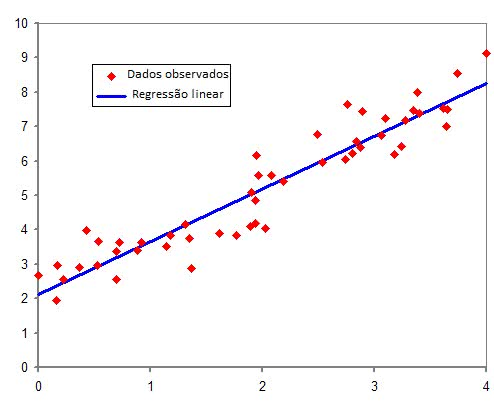

In [74]:
from IPython.display import Image
Image(filename='data/reglin.jpeg')

 Na regressão linear temos a formula abaixo, em que o valor de y (variável dependente ou reposta)é calculado pelo intercepto (ponto de contato com a linha re regressão com o eixo y) mais o coeficiente beta multiplicado pelo valor da variável x mais o erro. Se tivermos "n" variáveis teremos "n" coeficientes sendo multiplicados por n valores de suas respectivas variáveis. No nosso caso temos que n = 9.

$y = \beta_0 + \beta_1 x + \epsilon$

In [75]:
reglin0 = LinearRegression()
reglin0.fit(x_train_preproc, y_train)
y_pred_reglin0 = reglin0.predict(x_test_preproc)

In [76]:
reglin0_intercept = reglin0.intercept_.round(3)
reglin0_score = reglin0.score(x_train_preproc, 
                              y_train).round(3)
reglin0_mse = mean_squared_error(y_test, 
                                 y_pred_reglin0).round(3)
reglin0_mae = mean_absolute_error(y_test, 
                                  y_pred_reglin0).round(3)

print("=" * 46)
print("Regressão Linear - Modelo Base")
print("=" * 46)
print(f'Intercepto: {reglin0_intercept}')
print("-" * 46)
print('Coeficientes')
for col_name, coef in zip(x_train_preproc.columns, 
                          reglin0.coef_):
    print(col_name,'=', round(coef, 3))
print("-" * 46)
print(f'R²: {reglin0_score}')
print("-" * 46)
print(f'Erro quadrático médio: {reglin0_mse}')
print("-" * 46)
print(f'Erro absoluto médio: {reglin0_mae}')
print("=" * 46)

Regressão Linear - Modelo Base
Intercepto: 8338.756
----------------------------------------------
Coeficientes
age = 3715.138
bmi = 2076.404
children = 448.085
sex_male = 121.325
smoker_yes = 23700.333
region_northeast = 507.015
region_northwest = 168.044
region_southeast = -379.422
region_southwest = -295.638
----------------------------------------------
R²: 0.746
----------------------------------------------
Erro quadrático médio: 35087527.614
----------------------------------------------
Erro absoluto médio: 4193.042


Para o nosso modelo encontramos os valores de coeficiente que adicionados à formula teremos:

$y =  8338.756(intercepto) + 3715.13\times(idade) + 2076.404\times(imc) + 448.085\times(n\_filhos) + 121.325\times(homem) + 23700.333\times(tabagista) + 507.015\times(northeast) + 168.044\times(northwest) - 379.422\times(southeast) - 295.638\times(southwest) + ε$


Nesse caso o MAE foi maior do que o aceitável proposto no desafio. Vamos melhorar a análise fazendo uma validação cruzada.

## Validação cruzada

Essa técnica tem como objetivo averiguar se o a confiabilidade do modelo, fazendo varios treinos e testes com o conjunto de dados. Para isso dividimos os dados de treino em N partes iguais (digamos 5), dessa forma teremos 4 partes de treino e 1 de teste. Porém podemos executar esse processo alternando os dados de treino e teste como mostrado na imagem abaixo. Assim fazemos diversas experiencias, computamos as métricas de interesse e finalizado o processo podemos calcular a média das métricas e também comparar a performance de cada experiência.

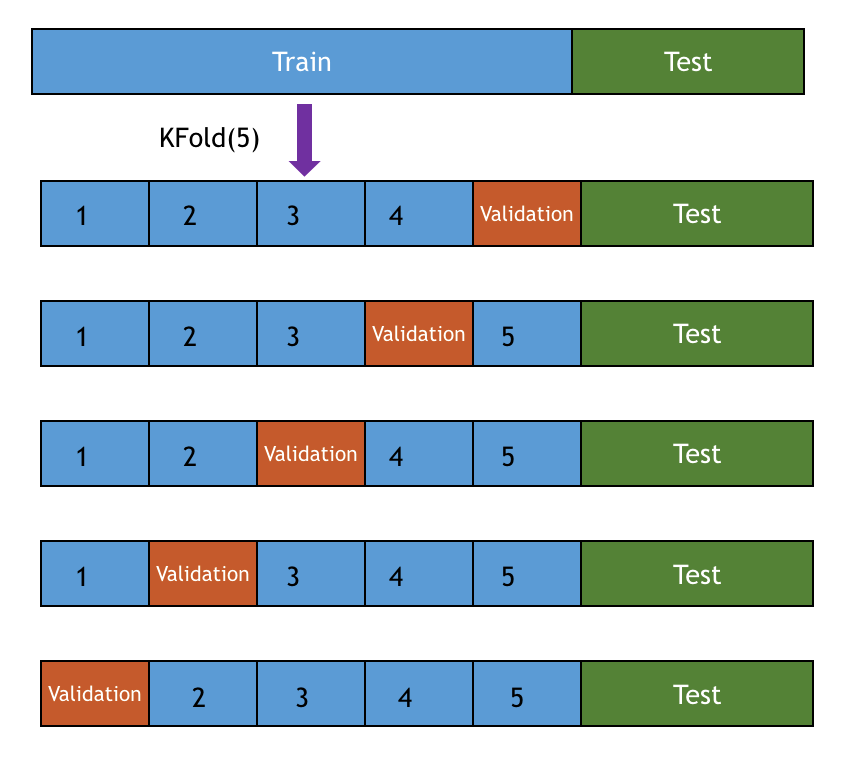

In [83]:
Image(filename='data/cross_validation_.png', width=500)

In [84]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
model_reg0 = LinearRegression()
scores0 = cross_val_score(model_reg0, x_train_preproc, 
                          y_train, cv=cv)
scores_mean0 = scores0.mean()

In [85]:
# Calculando MSE
mse_scores0 = cross_val_score(model_reg0, x_train_preproc, y_train, 
                              cv=cv, scoring=make_scorer(mean_squared_error))
mse_mean0 = mse_scores0.mean()

# Calculando MAE
mae_scores0 = cross_val_score(model_reg0, x_train_preproc, y_train, 
                              cv=cv, scoring=make_scorer(mean_absolute_error))
mae_mean0 = mae_scores0.mean()

In [86]:
print('=' * 72)
print('Regressão Linear - Validação Cruzada')
print('-' * 72)
print(f'Scores: {scores0.round(3)}')
print(f'Média : {round(scores_mean0, 3)}')
print(f'Desvio padrão : {round(scores0.std(), 3)}')
print('-' * 72)
print(f'MSE: {mse_scores0.round(3)}')
print(f'Média : {round(mse_mean0, 3)}')
print(f'Desvio padrão : {round(mse_scores0.std(), 3)}')
print('-' * 72)
print(f'MAE: {mae_scores0.round(3)}')
print(f'Média : {round(mae_mean0, 3)}')
print(f'Desvio padrão : {round(mae_scores0.std(), 3)}')
print('=' * 72)


Regressão Linear - Validação Cruzada
------------------------------------------------------------------------
Scores: [0.721 0.708 0.734 0.697 0.802]
Média : 0.732
Desvio padrão : 0.037
------------------------------------------------------------------------
MSE: [35609883.52  40049474.633 40330877.187 39524435.013 36233713.743]
Média : 38349676.819
Desvio padrão : 2008894.79
------------------------------------------------------------------------
MAE: [4100.779 4366.562 4273.459 4259.807 4393.116]
Média : 4278.745
Desvio padrão : 102.812


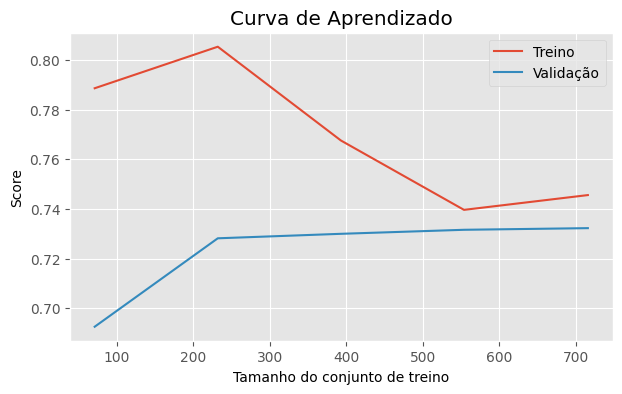

In [96]:
train_sizes0, train_scores0, valid_scores0 = learning_curve(
    model_reg0, x_train_preproc, y_train, cv=cv
)

train_scores_mean0 = np.mean(train_scores0, axis=1)
valid_scores_mean0 = np.mean(valid_scores0, axis=1)

plt.figure(figsize=(7, 4))
plt.plot(train_sizes0, train_scores_mean0, label='Treino')
plt.plot(train_sizes0, valid_scores_mean0, label='Validação')
plt.xlabel('Tamanho do conjunto de treino')
plt.ylabel('Score')
plt.title('Curva de Aprendizado')
plt.legend()
plt.show()


## Variáveis influentes

Nosso modelo inicial obteve algumas métricas interessantes já de início, porém temos muitas features sendo utilizadas para fazer as previsões.<br>
Quanto mais features no modelo mais complexo ele fica e possívelmente algumas estão contribuindo muito pouco ou até atrapalhando o nosso modelo para fazer melhores previsões, aumentando também o tempo de execução.<br>
Sendo assim tentaremos filtrar as variáveis mais importantes e as menos (ou nada) importantes para diminuirmos ruidos, construirmos um modelo mais eficiente, preciso e robusto.

Podemos utilizar alguns tipos de técnicas para selecionar as melhores variáveis para o nosso modelo:

- Filter (testes estatisticos para avaliar relação das variáveis com o alvo)
    - Coeficiente de correlação
    - SelectKBest
    - SelectFromModel
    - Mutual information
    - Teste Chi Quadrado



- Wrappper (métodos baseados em performance de modelos treinados com diferentes combinações de variáveis)
    - RFE
    - Foward/backward feature selection



- Embedded (combinação de seleção de variáveis com treino de modelos)
    - Lasso
    - Ridge
    - Elastic Net

- Dimensionality reduction
    - PCA
    - LDA
    - t-SNE

### Coeficiente de Correlação

### SelectKBest

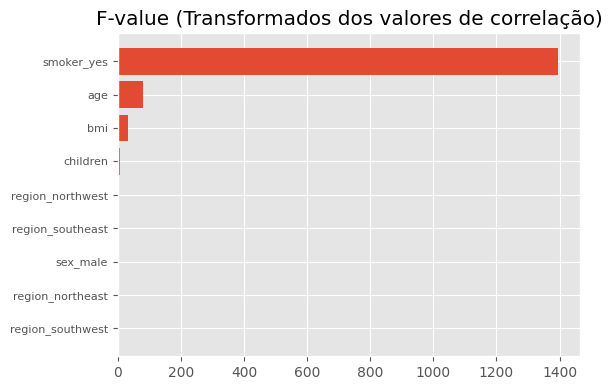

In [91]:
f_selector_1 = SelectKBest(score_func=f_regression, k='all')
f_selector_1.fit(x_train_preproc, y_train)

# Get the indices of the features sorted by F-values in descending order
sorted_indices = f_selector_1.scores_.argsort()

# Sort the features and their F-values based on the sorted indices
sorted_features = x_train_preproc.columns[sorted_indices]
sorted_scores = f_selector_1.scores_[sorted_indices]

plt.figure(figsize=(6, 4))
ax = plt.barh(range(len(sorted_scores)), sorted_scores)
plt.yticks(range(len(sorted_features)), sorted_features, 
           fontsize=8)
plt.title("F-value (Transformados dos valores de correlação)")
plt.tight_layout()
plt.show()


Variáveis mais influentes com SelectKBest - f_regresssion:
- tabagismo
- idade
- imc

### Mutual Information

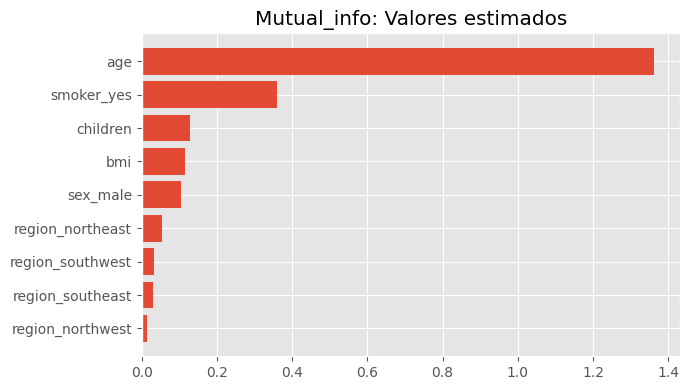

In [94]:
f_selector_2 = SelectKBest(score_func=mutual_info_regression, k='all')
f_selector_2.fit(x_train_preproc, y_train)

col_names = x_train_preproc.columns
mask = f_selector_2.get_support()
selected_features = x_train_preproc.columns[mask]

# Get the indices of the features sorted by mutual information scores in descending order
sorted_indices = f_selector_2.scores_[mask].argsort()

# Sort the selected features and their corresponding scores based on the sorted indices
sorted_features = selected_features[sorted_indices]
sorted_scores = f_selector_2.scores_[mask][sorted_indices]

plt.figure(figsize=(7, 4))
plt.barh(sorted_features, sorted_scores)
plt.title("Mutual_info: Valores estimados")
plt.tight_layout()
plt.show()


Variáveis mais influentes com SelectKBest - mutual_info_regresssion:
- idade
- tabagismo
- n_filhos e imc

### SelectFromModel

In [97]:
reglin_sfm = SelectFromModel(reglin0, prefit = True)
x_train_preproc_reglin_sfm = reglin_sfm.transform(x_train_preproc)
reglin_sfm_features = x_train_preproc.columns[reglin_sfm.get_support()]

print("=" * 65)
print(f"Selecionadas com SelectFromModel: {list(reglin_sfm_features)}")
print("=" * 65)

Selecionadas com SelectFromModel: ['age', 'smoker_yes']


d:\ciencia_de_dados\projetos\previsao_gastos_saude\venv\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


### RFE

In [101]:
reglin0_rfe = RFE(estimator = reglin0, n_features_to_select = 3)
reglin0_rfe.fit(x_train_preproc, y_train)
x_train_reglin0_rfe = reglin0_rfe.transform(x_train_preproc)
x_test_reglin0_rfe = reglin0_rfe.transform(x_test_preproc)
reglin0.fit(x_train_reglin0_rfe, y_train)
y_pred_reglin0_rfe = reglin0.predict(x_test_reglin0_rfe)
acuracia_reglin0_rfe = reglin0.score(x_test_reglin0_rfe, y_test)
print(f"Acurácia geral da regressão linear com RFE:\
    {round(acuracia_reglin0_rfe, 2)}")

Acurácia geral da regressão linear com RFE:    0.76


In [102]:
reglin0_rfe_support = reglin0_rfe.support_
reglin0_rfe_features = x_train_preproc.columns[reglin0_rfe_support]

print("="*59)
print(f"Variáveis selecionadas - RFE: {list(reglin0_rfe_features)}")
print("="*59)

Variáveis selecionadas - RFE: ['age', 'bmi', 'smoker_yes']


### Sequential Feature Selection

### LassoCV

In [103]:
alphas = [0.001, 0.01, 0.1, 1, 10]
lasso = LassoCV(cv=5, random_state = 42, 
                alphas = alphas)
lasso.fit(x_train_preproc, y_train)

LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5, random_state=42)

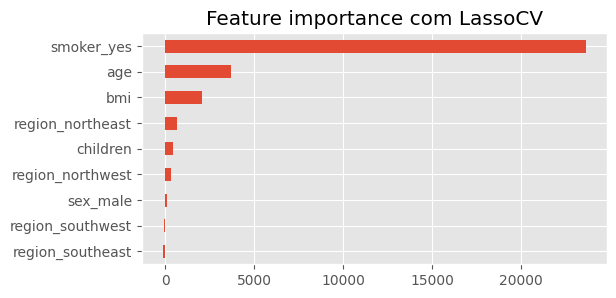

In [104]:
lasso_coef = pd.Series(lasso.coef_, index=x_train_preproc.columns)
lasso_imp_coef = lasso_coef.sort_values()

plt.rcParams['figure.figsize'] = (6, 3)
lasso_imp_coef.plot(kind="barh")
plt.title("Feature importance com LassoCV")
plt.show()

Variáveis mais influentes com LassoCV:
- tabagismo
- idade
- imc

### Ridge

In [105]:
alphas = [0.001, 0.01, 0.1, 1, 10]
ridge = RidgeCV(cv=5, alphas=alphas)
ridge.fit(x_train_preproc, y_train)

RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)

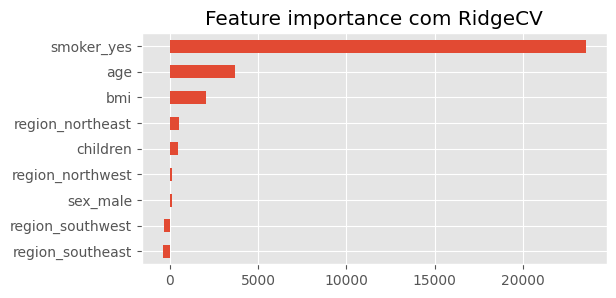

In [85]:
ridge_coef = pd.Series(ridge.coef_, index=x_train_preproc.columns)
ridge_imp_coef = ridge_coef.sort_values()

plt.rcParams['figure.figsize'] = (6, 3)
ridge_imp_coef.plot(kind="barh")
plt.title("Feature importance com RidgeCV")
plt.show()

Variáveis mais influentes com RidgeCV:
- tabagismo
- idade
- imc

### Elastic Net

In [106]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9]
elasticnet = ElasticNetCV(cv=5, alphas=alphas, l1_ratio=0.5)
elasticnet.fit(x_train_preproc, y_train)

d:\ciencia_de_dados\projetos\previsao_gastos_saude\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14712948.478702545, tolerance: 10209718.637070917
  model = cd_fast.enet_coordinate_descent_gram(
d:\ciencia_de_dados\projetos\previsao_gastos_saude\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36935062.00626373, tolerance: 10581545.748589031
  model = cd_fast.enet_coordinate_descent_gram(
d:\ciencia_de_dados\projetos\previsao_gastos_saude\venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.147e+09, tolerance: 1

ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100], cv=5)

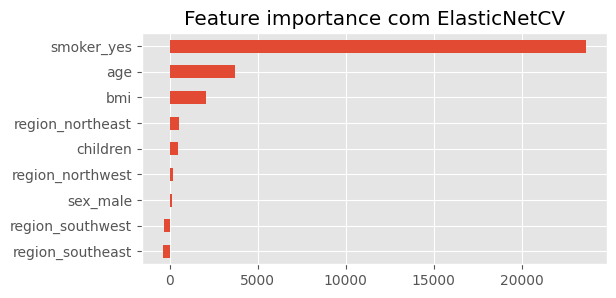

In [107]:
elasticnet_coef = pd.Series(elasticnet.coef_, index=x_train_preproc.columns)
elasticnet_imp_coef = elasticnet_coef.sort_values()

plt.figure(figsize=(6, 3))
elasticnet_imp_coef.plot(kind="barh")
plt.title("Feature importance com ElasticNetCV")
plt.show()

Variáveis mais influentes com ElasticNetCV:
- tabagismo
- idade
- imc

### Permutation Importance

In [108]:
reglin_permut = LinearRegression().fit(x_train_preproc, y_train)

# calculando permutation importance
result_permut = permutation_importance(reglin_permut, x_test_preproc, 
                                       y_test, n_repeats=10, random_state=0)

importances = result_permut.importances_mean
indices = np.argsort(importances)[::-1]
for f in range(x_train_preproc.shape[1]):
    print("%d. %s (%f)" % (f + 1, x_test_preproc.columns[indices[f]], 
                           importances[indices[f]]))

1. smoker_yes (1.260117)
2. age (0.159435)
3. bmi (0.060419)
4. children (0.005249)
5. region_northeast (0.001192)
6. region_southeast (0.000799)
7. region_southwest (0.000425)
8. region_northwest (0.000140)
9. sex_male (-0.000233)


Variáveis mais influentes com Permutation Importance:
- tabagismo
- idade
- imc

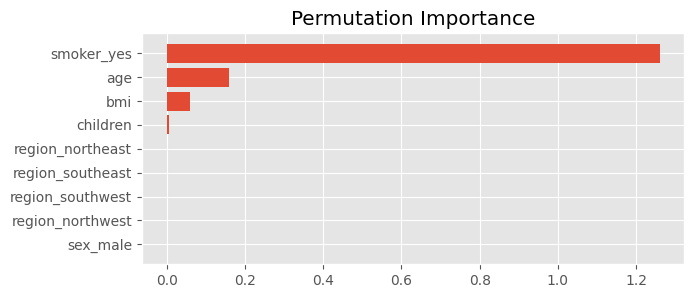

In [109]:
# Plotando feature importances
plt.figure(figsize=(7, 3))
plt.title("Permutation Importance")
plt.barh(range(x_test_preproc.shape[1]), 
         importances[indices][::-1])
plt.yticks(range(x_test_preproc.shape[1]), 
           x_test_preproc.columns[indices][::-1])
plt.show()

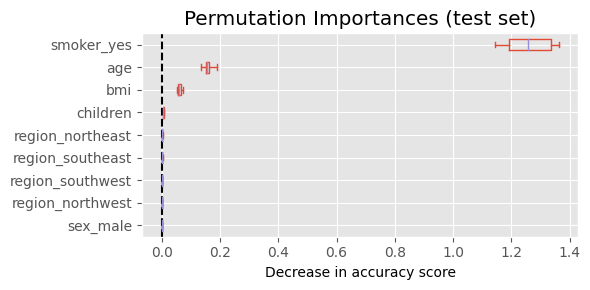

In [110]:
sorted_importances_idx = result_permut.importances_mean.argsort()
importances = pd.DataFrame(
    result_permut.importances[sorted_importances_idx].T,
    columns=x_train_preproc.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

Novamente temos as mesmas 3 variáveis se destacando.

## Otimizando modelo

Nosso modelo pode ser melhorado tanto pela retirada de variáveis que causam ruído e limitam a performance do modelo, quanto alterando o modelo utilizado.

In [112]:
features_selecionadas = ['bmi', 'age', 'smoker_yes']

### Modelo com variáveis filtradas

In [113]:
reglin1 = LinearRegression()
reglin1.fit(x_train_preproc[features_selecionadas], y_train)
y_pred_reglin1 = reglin1.predict(x_test_preproc[features_selecionadas])

In [114]:
reglin1_intercept = reglin1.intercept_.round(3)
reglin1_score = reglin1.score(x_train_preproc[features_selecionadas], 
                              y_train).round(3)
reglin1_mse = mean_squared_error(y_test, y_pred_reglin1).round(3)
reglin1_mae = mean_absolute_error(y_test, y_pred_reglin1).round(3)

print("="*46)
print("Regressão Linear - Features Filtradas")
print("="*46)
print(f'Intercepto: {reglin1_intercept}')
print("-"*46)
print('Coeficientes')
for col_name, coef in zip(x_train_preproc[features_selecionadas].columns, 
                          reglin1.coef_):
    print(col_name,'=', round(coef, 3))
print("-"*46)
print(f'R²: {reglin1_score}')
print("-"*46)
print(f'Erro quadrático médio: {reglin1_mse}')
print("-"*46)
print(f'Erro absoluto médio: {reglin1_mae}')
# print("-"*46)
# print(f'Tempo de execução: {round(reglin1_total, 3)}s')
print("="*46)

Regressão Linear - Features Filtradas
Intercepto: 8398.635
----------------------------------------------
Coeficientes
bmi = 1980.923
age = 3758.282
smoker_yes = 23739.488
----------------------------------------------
R²: 0.743
----------------------------------------------
Erro quadrático médio: 35822015.92
----------------------------------------------
Erro absoluto médio: 4249.469


$y =  8398.635(intercepto) + 3758.282\times(idade) + 1980.923\times(imc) + 23739.488\times(tabagista) + ε$

In [115]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
model_reg1 = LinearRegression()
scores1 = cross_val_score(model_reg1, x_train_preproc[features_selecionadas], 
                          y_train, cv=cv)
scores_mean1 = scores1.mean()

In [116]:
# Calculando MSE
mse_scores1 = cross_val_score(model_reg1, x_train_preproc[features_selecionadas], 
                              y_train, cv=cv, scoring=make_scorer(mean_squared_error))
mse_mean1 = mse_scores1.mean()

# Calculando MAE
mae_scores1 = cross_val_score(model_reg1, x_train_preproc[features_selecionadas], 
                              y_train, cv=cv, scoring=make_scorer(mean_absolute_error))
mae_mean1 = mae_scores1.mean()

In [117]:
print('='*72)
print('Regressão Linear [IMC, idade, tabagismo] - Validação Cruzada')
print('-'*72)
print(f'Scores: {scores1.round(3)}')
print(f'Média : {round(scores_mean1, 3)}')
print(f'Desvio padrão : {round(scores1.std(), 3)}')
print('-'*72)
print(f'MSE: {mse_scores1.round(3)}')
print(f'Média : {round(mse_mean1, 3)}')
print(f'Desvio padrão : {round(mse_scores1.std(), 3)}')
print('-'*72)
print(f'MAE: {mae_scores1.round(3)}')
print(f'Média : {round(mae_mean1, 3)}')
print(f'Desvio padrão : {round(mae_scores1.std(), 3)}')
print('='*72)


Regressão Linear [IMC, idade, tabagismo] - Validação Cruzada
------------------------------------------------------------------------
Scores: [0.723 0.715 0.734 0.695 0.8  ]
Média : 0.734
Desvio padrão : 0.036
------------------------------------------------------------------------
MSE: [35230164.409 39041944.99  40375465.932 39751464.509 36570463.501]
Média : 38193900.668
Desvio padrão : 1965893.799
------------------------------------------------------------------------
MAE: [4101.942 4269.87  4290.652 4300.635 4425.898]
Média : 4277.799
Desvio padrão : 103.546


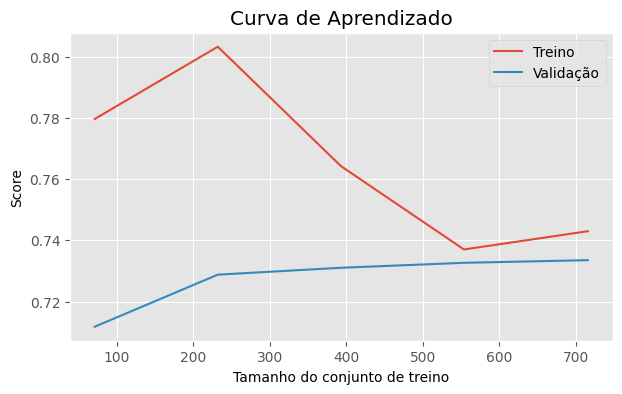

In [118]:
train_sizes1, train_scores1, valid_scores1 = learning_curve(
    model_reg1, 
    x_train_preproc[features_selecionadas], 
    y_train, cv=cv
)

train_scores_mean1 = np.mean(train_scores1, axis=1)
valid_scores_mean1 = np.mean(valid_scores1, axis=1)

plt.figure(figsize=(7, 4))
plt.plot(train_sizes1, train_scores_mean1, label='Treino')
plt.plot(train_sizes1, valid_scores_mean1, label='Validação')
plt.xlabel('Tamanho do conjunto de treino')
plt.ylabel('Score')
plt.title('Curva de Aprendizado')
plt.legend()
plt.show()


Utilizando o modelo com variáveis filtradas obtivemos alguma variação mas ainda não dentro do limite aceitável. Porém conseguimos simplificar o nosso modelo, já que utilizamos somente 3 variáveis e obtivemos os mesmos resultados.

## Transformação polinomial

Há também a possibilidade de utilizarmos uma extensão da regressão linear simples que permite modelar relações não-lineares entre a variável de resposta/alvo (dependente) e a(s) variável(is) independente(s).

Nesse caso teremos uma uma curva ajustada aos dados e a forma dessa curva é determinada pelo grau do polinômio usado.

No exemplo abaixo vemos que a relação entre a variável x e y não é linear, desse modo a linha reta azul (modelo linear) não se adequa da melhor forma a explicar os dados (primeiro gráfico). Então foram propostas funções polinomiais de IV grau (segundo gráfico) e XV grau (terceiro gráfico). É importante notar que no segundo modelo ainda há erros, mas a linha consegue acompanhar de forma adequada as oscilações nos dados observados, já no ultimo gráfico podemos ver overfit do modelo, pois a linha azul intercepta quase que perfeitamente todos os dados do modelo. 

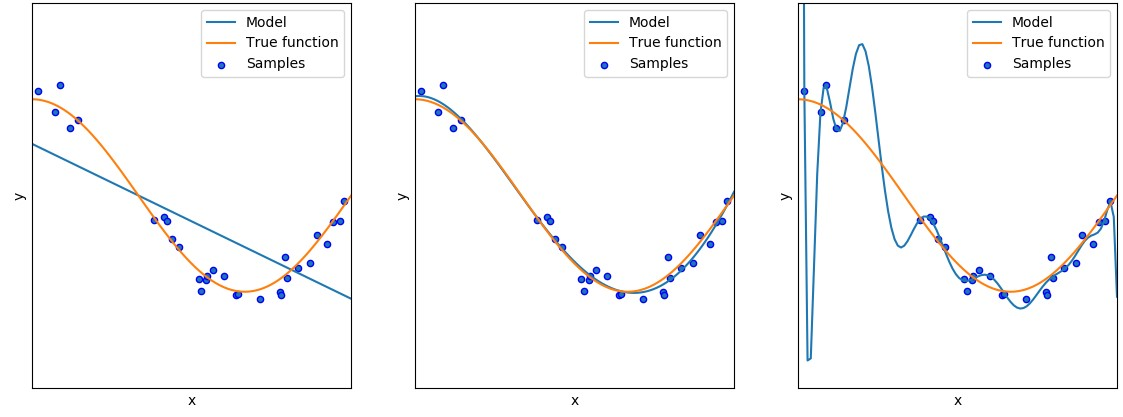

In [98]:
Image(filename='data/regpoly.jpeg')

Vamos investigar qual grau da função polinomial é mais adequado para o nosso problema

In [119]:
r2_poly = []
mse_poly = []
mae_poly = []
order = [1, 2, 3, 4, 5, 6]

for n in order:
    reglin_poly = LinearRegression()
    pr = PolynomialFeatures(degree=n)
    x_train_pr = pr.fit_transform(x_train_preproc[features_selecionadas])
    x_test_pr =  pr.transform(x_test_preproc[features_selecionadas])
    reglin_poly.fit(x_train_pr, y_train)
    y_pred_poly = reglin_poly.predict(x_test_pr)
    r2_poly.append(reglin_poly.score(x_test_pr, y_test).round(3))
    mse_poly.append(mean_squared_error(y_test, y_pred_poly).round(3))
    mae_poly.append(mean_absolute_error(y_test, y_pred_poly).round(3))

In [120]:
r2 = pd.DataFrame({"ordem": order, "r²": r2_poly, 
                   "mse": mse_poly, "mae": mae_poly})
r2.set_index('ordem', inplace=True)

In [121]:
r2.sort_values(by='r²', ascending=False)

,r²,mse,mae
ordem,,,
3,0.848,22243211.719,2820.602
2,0.847,22486957.297,2843.028
5,0.838,23681478.589,2802.108
4,0.829,25042950.329,2829.045
1,0.756,35822015.920,4249.469
6,0.755,35910790.412,2928.180


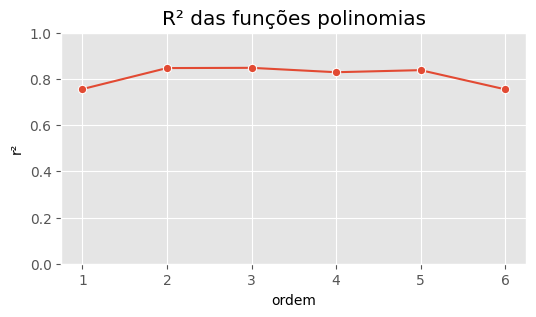

In [123]:
plt.figure(figsize = (6,3))
sns.lineplot(data=r2, x='ordem', y='r²', marker='o')
plt.title("R² das funções polinomias")
plt.ylim([0, 1])
plt.show()

Podemos ver que a função polinomial de III° nos traz um R² maior, ou seja nosso modelo conseguiu explicar 84% da variabilidade dos gastos. Porém a variação em relação a função polinomial de II° é pequena, e quanto maior o grau do polinomio mais complexo o modelo é, apesar da simplicidade da regressão linear. Por isso vamos utilizar a função de II° para o nosso modelo.

In [124]:
pr2 = PolynomialFeatures(degree=2)
x_train_pr2 = pr2.fit_transform(x_train_preproc[features_selecionadas])
x_test_pr2 =  pr2.transform(x_test_preproc[features_selecionadas])

reglin_poly2 = LinearRegression()
reglin_poly2.fit(x_train_pr2, y_train)
y_pred_poly2 = reglin_poly2.predict(x_test_pr2)
reglin_poly2_intercept = reglin_poly2.intercept_.round(3)
r2_poly2 = reglin_poly2.score(x_test_pr2, y_test).round(3)
mse_poly2 = mean_squared_error(y_test, y_pred_poly2).round(3)
mae_poly2 = mean_absolute_error(y_test, y_pred_poly2).round(3)

In [125]:
print("="*46)
print("Regressão Linear - Função Polinomial II°")
print("="*46)
print(f'Intercepto: {reglin_poly2_intercept}')
print("-"*46)
print(f'R²: {r2_poly2}')
print("-"*46)
print(f'Erro quadrático médio: {mse_poly2}')
print("-"*46)
print(f'Erro absoluto médio: {mae_poly2}')
print("="*46)

Regressão Linear - Função Polinomial II°
Intercepto: 8172.56
----------------------------------------------
R²: 0.847
----------------------------------------------
Erro quadrático médio: 22486957.297
----------------------------------------------
Erro absoluto médio: 2843.028


In [127]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
model_reg_pr2 = LinearRegression()
scores_pr2 = cross_val_score(model_reg_pr2, x_train_pr2, 
                             y_train, cv=cv)
scores_mean_pr2 = scores_pr2.mean()

In [128]:
# Calculando MSE
mse_scores_pr2 = cross_val_score(model_reg_pr2, x_train_pr2, y_train, cv=cv, 
                                 scoring=make_scorer(mean_squared_error))
mse_mean_pr2 = mse_scores_pr2.mean()

# Calculando MAE
mae_scores_pr2 = cross_val_score(model_reg_pr2, x_train_pr2, y_train, cv=cv, 
                                 scoring=make_scorer(mean_absolute_error))
mae_mean_pr2 = mae_scores_pr2.mean()

In [131]:
print('='*72)
print('Regressão Linear Poli II° [IMC, idade, tabagismo] - Validação Cruzada')
print('-'*72)
print(f'Scores: {scores_pr2.round(3)}')
print(f'Média : {round(scores_mean_pr2, 3)}')
print(f'Desvio padrão : {round(scores_pr2.std(), 3)}')
print('-'*72)
print(f'MSE: {mse_scores_pr2.round(3)}')
print(f'Média : {round(mse_mean_pr2, 3)}')
print(f'Desvio padrão : {round(mse_scores_pr2.std(), 3)}')
print('-'*72)
print(f'MAE: {mae_scores_pr2.round(3)}')
print(f'Média : {round(mae_mean_pr2, 3)}')
print(f'Desvio padrão : {round(mae_scores_pr2.std(), 3)}')
print('='*72)


Regressão Linear Poli II° [IMC, idade, tabagismo] - Validação Cruzada
------------------------------------------------------------------------
Scores: [0.829 0.805 0.804 0.813 0.886]
Média : 0.828
Desvio padrão : 0.031
------------------------------------------------------------------------
MSE: [21775603.321 26748658.185 29673299.007 24326857.964 20852492.193]
Média : 24675382.134
Desvio padrão : 3237972.218
------------------------------------------------------------------------
MAE: [2881.889 3249.718 3181.868 2954.991 2936.007]
Média : 3040.895
Desvio padrão : 146.386


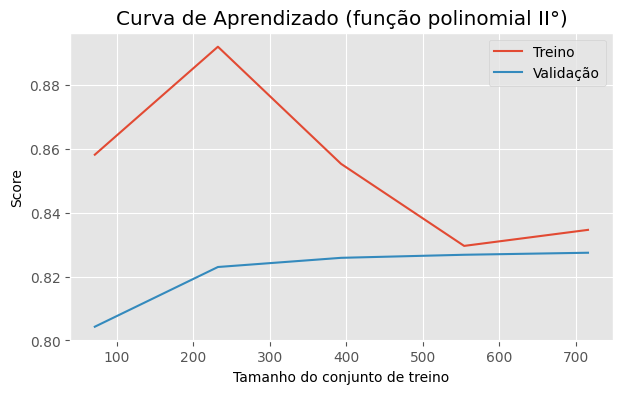

In [133]:
train_sizes_pr2, train_scores_pr2, valid_scores_pr2 = learning_curve(
    model_reg_pr2, x_train_pr2, y_train, cv=cv
)

train_scores_mean_pr2 = np.mean(train_scores_pr2, axis=1)
valid_scores_mean_pr2 = np.mean(valid_scores_pr2, axis=1)

plt.figure(figsize=(7, 4))
plt.plot(train_sizes_pr2, train_scores_mean_pr2, label='Treino')
plt.plot(train_sizes_pr2, valid_scores_mean_pr2, label='Validação')
plt.xlabel('Tamanho do conjunto de treino')
plt.ylabel('Score')
plt.title('Curva de Aprendizado (função polinomial II°)')
plt.legend()
plt.show()


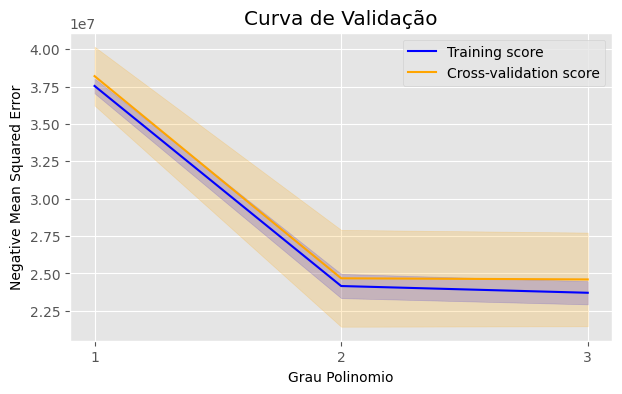

In [134]:
model_reg2 = LinearRegression()
# Define the degrees for polynomial features
degrees = [1, 2, 3]

# Create a pipeline with PolynomialFeatures and LinearRegression
pipeline = make_pipeline(PolynomialFeatures(), model_reg2)

# Compute validation scores for different degrees
train_scores, valid_scores = validation_curve(
    estimator=pipeline,
    X=x_train_preproc[features_selecionadas],
    y=y_train,
    param_name='polynomialfeatures__degree',
    param_range=degrees,
    cv=cv,
    scoring='neg_mean_squared_error'
)

# Calculate the mean and standard deviation of validation scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = -np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

# Plot the validation curves
plt.figure(figsize=(7, 4))
plt.plot(degrees, train_scores_mean, 
         label='Training score', color='blue')
plt.fill_between(degrees, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color='blue')
plt.plot(degrees, valid_scores_mean, 
         label='Cross-validation score', color='orange')
plt.fill_between(degrees, valid_scores_mean - valid_scores_std, 
                 valid_scores_mean + valid_scores_std, 
                 alpha=0.2, color='orange')
plt.title('Curva de Validação')
plt.xlabel('Grau Polinomio')
plt.ylabel('Negative Mean Squared Error')
plt.legend(loc='best')
plt.xticks(degrees)
plt.show()

A transformação polinomial de II° foi suficiente para conseguirmos um MAE abaixo do limiar estipulado.

Conseguimos um modelo de regressão dentro do limite proposto.

# 6.Conclusão

Com uma função polinomial de grau II conseguimos implementar um modelo relativamente simples para resolver o problema.

Pelas análises e resultado do nosso modelo podemos concluir que alguns hábitos influenciam na saúde e consequentemente nos gastos. Das 3 variáveis mais importantes para o modelo 2 delas, IMC e Tabagismo, são fatores modificáveis. Isso pode ser alcançado com exercícios físicos, dieta apropriada e acompanhamento com profissionais da saúde. 

O acompanhamento com profissionais é de extrema importancia e muitas vezes negligenciado, ou até indisponível devido alto custo, porém deveria ser uma das principais formas de abordar o problema, pois o tabagismo e dieta inapropriada tem grande relação com o modo de vida atual e as consequências que ele nos traz, sendo muitas vezes utilizados como válvula de escape para enfrentamento de questões psicossociais. 
Dessa forma profissionais como psicologos, educadores físicos e nutricionistas se tornam componentes essenciais para o processo de mudança de hábito ser satisfatório e adequado.

# Referências

- https://scikit-learn.org/stable/getting_started.html

- https://machinelearningmastery.com/data-preparation-without-data-leakage/